<a href="https://colab.research.google.com/github/Undreak/MML_Nombres_Premiers/blob/master/Nombres_Premiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Nombres Premiers

> **Groupe D**
>
> Alexandre De Cuyper
>
> Hendrix Montalvan

1. [Introduction](#Introduction)
2. [Données](#Données)
3. [Modèle](#Modèle)
4. [Résultats](#Résultats)

## Introduction

---

On cherche a faire un réseau qui prédit si un nombre est un nombre premier. 

On va utiliser l'apprentissage supervisé avec une classification binaire (nombres premiers et les multiples). On va diviser les données en 2 groupes: entrainement et test. Pour les algorithmes on va essayer les méthodes Linear SVM, RBF SVM, Random Forest, etc; et voir quelle est la méthode qui prédit mieux les nombres premiers dehors des données d'apprentissage.

---

Dans ce Notebook nous allons voir si un réseau de neurones est capable de prédire si un nombre est premier ou non en lui montrant un jeu de données de plusieurs millions de nombres premiers.

Nous allons pour cela tester 2 types de datasets différents, un contenant les multiples des nombres et un autre sans, afin de voir comment cette information va impacter l'apprentissage du réseau et par conséquent ses prédicitons.

## Importations néscessaires

In [12]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import keras
import keras.models as km
import keras.layers as kl

Using TensorFlow backend.


## Données

In [4]:
#@title Options pour les datasets
#@markdown Choisissez les datasets à importer

use_primes = True #@param {type:"boolean"}
suffix = "" if use_primes else "_mini"
use_primes_with_multiples = True #@param {type:"boolean"}
suffix = "" if use_primes_with_multiples else "_mini"

In [10]:
#@title Télécharger les données

#@markdown Ceci va télécharger l'archive depuis Github et la décompresser dans le répertoire `data`

import sys
import os
import tarfile
from urllib.request import urlretrieve

URL = "https://github.com/Undreak/MML_Nombres_Premiers/raw/master"
FILES = [
    "prime_with_multiples.tar.gz",
    "primes.tar.gz"
]


def download_data(output_dir, use_primes=True, use_primes_with_multiples=False):
  if use_primes_with_multiples:
    file = FILES[0]
  if use_primes:
    file = FILES[1]
  if use_primes and use_primes_with_multiples:
    files = FILES
  urls = [
         f"{URL}/{filename}"
         for filename in files
  ]
  
  if not os.path.exists(output_dir):
    print(f"Création du répertoire {output_dir}")
    os.mkdir(output_dir)
  
  for url, filename in zip(urls, files):
    output_file = os.path.join(output_dir, filename)
    if os.path.exists(output_file):
      print(f"{filename} déjà téléchargé.")
      continue

    print(f"Téléchargement à partir de {url}...")
    urlretrieve(url, output_file)
    print(f"==> Fichier enregistré sous {output_file}")

    if filename.endswith("tar.gz"):
      print("Extraction de l'archive...")
      with tarfile.open(output_file, "r:gz") as f:
        f.extractall(output_dir)
      print("Terminé.\n")

download_data("data", use_primes, use_primes_with_multiples)

prime_with_multiples.tar.gz déjà téléchargé.
primes.tar.gz déjà téléchargé.


### Préparation des datasets

Les bases de données au format `.accdb` sont disponible ici: https://aaabit.com/Prime-Numbers

On a exécuté la fonction suivante pour convertir les fichiers.

In [ ]:
import pypyodbc
import numpy as np
pypyodbc.lowercase = False
conn = pypyodbc.connect(
    r"Driver={Microsoft Access Driver (*.mdb, *.accdb)};" +
    r"Dbq=C:\\Users\\leibn\\Prime numbers\\nom_du_fichier.accdb;") #Ici il faut remplacer par le nom du fichier en format access
cur = conn.cursor()
cur.execute("SELECT prime_index, prime_n FROM primes_tbl");
n=7603553  #n: quantité de nombres premiers qui sont dans le dataset
prime=np.zeros(n)
i=0
for i in range(n):
    row = cur.fetchone()
    prime[i]=row.get("prime_n")
print(prime)
cur.close()
conn.close()

Puis pour obtenir les multiples des nombres du dataset nous avons utilisé ces fonctions.

In [4]:
def numbers_to_digits(number,max_digit,base): #Cette fonction convertit les nombres en chiffres en base decimale
    tab=np.zeros(max_digit)
    i=0
    for i in range(max_digit):
        tab[i]=number%base
        number=number//base
    return tab

def add_random_multiples(tab,max_digit,base): #Cette fonction ajoute des nombres multiples au dataset
    dim=2*len(tab)-1
    output_tab=np.zeros((dim,max_digit+1))
    output_tab[0][0]=0
    output_tab[0,1:]=numbers_to_digits(1,max_digit,base)
    i=0
    prev_value=1
    p=1
    while p<dim:
        diff=tab[i]-prev_value
        if diff==1:
            output_tab[p][0]=1
            output_tab[p,1:]=numbers_to_digits(tab[i],max_digit,base)
            prev_value=tab[i]
            p=p+1
            i=i+1
        elif diff==2:
            output_tab[p][0]=0
            output_tab[p,1:]=numbers_to_digits(tab[i]-1,max_digit,base)
            p=p+1
            output_tab[p][0]=1
            output_tab[p,1:]=numbers_to_digits(tab[i],max_digit,base)
            prev_value=tab[i]
            p=p+1
            i=i+1
            if i==len(tab):
                p=dim
            else:
                pass
        elif diff>2:
            random=np.random.randint(1,diff)
            output_tab[p][0]=0
            output_tab[p,1:]=numbers_to_digits(tab[i-1]+random,max_digit,base)
            p=p+1
            output_tab[p][0]=1
            output_tab[p,1:]=numbers_to_digits(tab[i],max_digit,base)
            prev_value=tab[i]
            p=p+1
            i=i+1
            if i==len(tab):
                p=dim
            else:
                pass
        else:
            pass
    return output_tab
            

Les données compressé téléchargé depuis Github sont déjà préparé au format `.csv` et peuvent être lu par pandas ou numpy.

Si on veux travailler avec un dataset en base décimale:

In [ ]:
prime_with_multiples=add_random_multiples(prime,9,10)
df = pd.DataFrame({'prime': prime_with_multiples[:,0],
                   '1': prime_with_multiples[:,1],
                   '2': prime_with_multiples[:,2],
                   '3': prime_with_multiples[:,3],
                   '4': prime_with_multiples[:,4],
                   '5': prime_with_multiples[:,5],
                   '6': prime_with_multiples[:,6],
                   '7': prime_with_multiples[:,7],
                   '8': prime_with_multiples[:,8],
                   '9': prime_with_multiples[:,9]})
df.to_csv('prime_with_multiples_binaire.csv', index=False)

Si on veux travailler avec un dataset binaire:

In [8]:
prime_with_multiples=add_random_multiples(prime,28,2)
df_binaire = pd.DataFrame({'prime': prime_with_multiples[:,0],
                   '1': prime_with_multiples[:,1],
                   '2': prime_with_multiples[:,2],
                   '3': prime_with_multiples[:,3],
                   '4': prime_with_multiples[:,4],
                   '5': prime_with_multiples[:,5],
                   '6': prime_with_multiples[:,6],
                   '7': prime_with_multiples[:,7],
                   '8': prime_with_multiples[:,8],
                   '9': prime_with_multiples[:,9],
                   '10': prime_with_multiples[:,10],
                   '11': prime_with_multiples[:,11],
                   '12': prime_with_multiples[:,12],
                   '13': prime_with_multiples[:,13],
                   '14': prime_with_multiples[:,14],
                   '15': prime_with_multiples[:,15],
                   '16': prime_with_multiples[:,16],
                   '17': prime_with_multiples[:,17],
                   '18': prime_with_multiples[:,18],
                   '19': prime_with_multiples[:,19],
                   '20': prime_with_multiples[:,20],
                   '21': prime_with_multiples[:,21],
                   '22': prime_with_multiples[:,22],
                   '23': prime_with_multiples[:,23],
                   '24': prime_with_multiples[:,24],
                   '25': prime_with_multiples[:,25],
                   '26': prime_with_multiples[:,26],
                   '27': prime_with_multiples[:,27],
                   '28': prime_with_multiples[:,28]})
df_binaire.to_csv('prime_with_multiples_binaire.csv', index=False)

### Charger les données

Chargement des données du dataset sans les multiples

In [42]:
data = pd.read_csv('data/primes.csv', skiprows=1, delimiter=',').astype(int)

In [196]:
N = 100000

X_train = np.arange(2,N+2)
Y_train = np.isin(X_train, data['2'][:N])*1

X_test = np.arange(N+3, 2*N+3)
Y_test = np.isin(X_test, data['2'][N+3:2*N+3])*1

Chargement des données du dataset avec les multiples

In [75]:
df = pd.read_csv("data/prime_with_multiples.csv")

In [191]:
N = 100000

Y_train = df['prime'][:N]
X_train = np.zeros((N,9))
for i in range(9):
  X_train[:,i] = df[f"{i+1}"][:N]

Y_test = df['prime'][N+1:2*N+1]
X_test = np.zeros((N,9))
for i in range(9):
  X_test[:,i] = df[f"{i+1}"][N+1:2*N+1]

## Modèle

On construit un réseau de neurones convolutif

In [197]:
f_activation = 'relu'
l_activation = 'sigmoid'
dropout_rate = 0.05
if use_primes_with_multiples:
  input_dim = 9
else:
  input_dim = 1
model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, activation=f_activation, input_dim=input_dim),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(32, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(32, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(64, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(128, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(1, activation=l_activation)
])

model.compile(optimizer='Adam', loss='binary_crossentropy')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 16)                32        
_________________________________________________________________
dropout_80 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_97 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_81 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_82 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 64)              

In [198]:
history = model.fit(X_train, Y_train,
  batch_size=32,
  epochs=15,
  validation_split=0.3,
  verbose=1)

Train on 70000 samples, validate on 30000 samples
Epoch 1/15
70000/70000 [==============================] - 13s 183us/sample - loss: 6.0540 - val_loss: 0.3002
Epoch 2/15
70000/70000 [==============================] - 10s 147us/sample - loss: 0.3910 - val_loss: 0.2995
Epoch 3/15
70000/70000 [==============================] - 10s 141us/sample - loss: 0.3442 - val_loss: 0.3001
Epoch 4/15
70000/70000 [==============================] - 10s 145us/sample - loss: 0.3271 - val_loss: 0.3013
Epoch 5/15
70000/70000 [==============================] - 10s 140us/sample - loss: 0.3285 - val_loss: 0.2999
Epoch 6/15
70000/70000 [==============================] - 10s 138us/sample - loss: 0.3283 - val_loss: 0.2997
Epoch 7/15
70000/70000 [==============================] - 10s 138us/sample - loss: 0.3256 - val_loss: 0.3007
Epoch 8/15
70000/70000 [==============================] - 10s 139us/sample - loss: 0.3239 - val_loss: 0.2991
Epoch 9/15
70000/70000 [==============================] - 10s 139us/sample - l

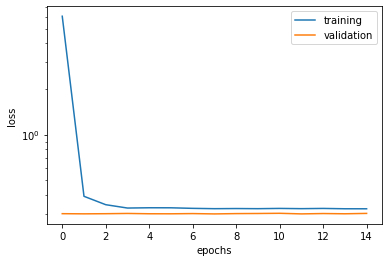

100000/100000 [==============================] - 6s 55us/sample - loss: 0.1158
0.11576534062623978


In [199]:
plt.figure()                    
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

ev = model.evaluate(X_test, Y_test)
print(ev)

### Réseau utilisé pour le dataset avec multiples

In [182]:
model = km.Sequential()
activation_input='tanh'
model.add(kl.Dense(100, activation=activation_input , input_dim=9))
model.add(kl.Dense(50, activation=activation_input ))
model.add(kl.Dense(20, activation=activation_input ))
model.add(kl.Dense(10, activation=activation_input ))
model.add(kl.Dense(5, activation=activation_input ))
model.add(kl.Dense(1, activation='linear'))
model.compile(optimizer='Adam', loss='mse')

## Résultats